# Read Raster File

*Author: Creare* <br>
*Date: April 01 2020* <br>

**Keywords**: podpac, DataSource, Rasterio

## Overview

Reference tutorial for loading Raster data (such as GeoTIFs) with the `podpac.data.Rasterio` Node.

### Prerequisites

- Python 2.7 or above
- [`podpac[datatype]`](https://podpac.org/install.html#install)
- *Review the [README.md](../README.md) and [jupyter-tutorial.ipynb](jupyter-tutorial.ipynb) for additional info on using jupyter notebooks*

### See Also

- [0-concepts/introduction.ipynb](introduction.ipynb): PODPAC introduction
- [0-concepts/coordinates.ipynb](../0-concepts/coordinates.ipynb): PODPAC Coordinates reference
- [`podpac.data.Rasterio` API Reference](https://podpac.org/api/podpac.data.Rasterio.html#podpac.data.Rasterio)

## How to open a raster file with PODPAC

The `podpac.data.Rasterio` node reads raster files such as GeoTIFs. 
PODPAC wraps the [rasterio](https://rasterio.readthedocs.io/en/stable/) Python package (which wraps `gdal`) to read raster files.

The following example reads a SRTM GeoTIF elevation file.

In [1]:
# plot inline
%matplotlib inline

In [2]:
import podpac

# Relative filepath to a geotif file in the podpac_examples/data directory
filename = '../../data/raster/n39_w107_1arc_v2.tif'

# Set up the PODPAC node to read this file
# NOTE: rasterio throw a warning like "CPLE_NotSupported in driver GTiff does not support open option MODE" which can be ignored
node = podpac.data.Rasterio(source=filename)

node

<Rasterio(source='../../data/raster/n39_w107_1arc_v2.tif')>

## Read and display raster data

In [3]:
# this evaluation retrieves all of the data at the native resolution into memory and loads data into an podpac UnitsDataArray
output = node.eval(node.native_coordinates)
output

<xarray.UnitsDataArray (lat: 3601, lon: 3601)>
array([[2992., 2989., 2985., ..., 2801., 2799., 2798.],
       [2991., 2986., 2980., ..., 2809., 2806., 2803.],
       [2987., 2981., 2974., ..., 2812., 2809., 2805.],
       ...,
       [3128., 3136., 3143., ..., 2828., 2830., 2833.],
       [3128., 3135., 3143., ..., 2828., 2828., 2831.],
       [3129., 3138., 3144., ..., 2827., 2828., 2831.]])
Coordinates:
  * lat      (lat) float64 40.0 40.0 40.0 40.0 40.0 ... 39.0 39.0 39.0 39.0 39.0
  * lon      (lon) float64 -107.0 -107.0 -107.0 -107.0 ... -106.0 -106.0 -106.0
Attributes:
    layer_style:   <podpac.core.style.Style object at 0x000001F6AA223940>
    crs:           EPSG:4326
    geotransform:  (-107.00013888888888, 0.0002777777777777778, 0.0, 40.00013...

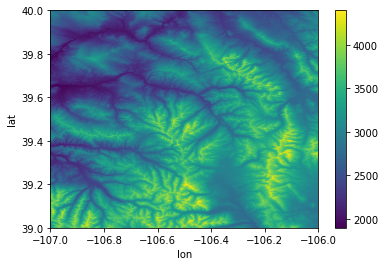

In [4]:
# plot data at native coordinates
# this can take a little while on slower machines
output.plot()
pass